# PHÂN LOẠI LAPTOP DỰA THEO CÁC THÔNG SỐ CHO TRƯỚC

## Thành viên

- **1612001**: Hoàng Dân An

- **1612165**: Nguyễn Đào Vinh Hải


## Bài Toán

Dựa vào các thông số cho trước của laptop:

1. RAM

2. CPU Chipset (exp Intel Core i7, AMD Ryzen, ...)

3. Dòng CPU (9750H)
    
3. Dung dượng ổ cứng

4. Card đồ họa rời (exp: Nvidia, AMD, ...)

5. Có SSD hay không?

6. Độ phân giải màn hình (exp: 1920x1080, ...)

7. Khối lượng


Để phân loại laptop này theo 3 loại:

1. Gaming (chơi game)

2. Học tập - Văn phòng

3. Đồ họa (thiết kế, render video/image)


## Ứng dụng

- Phân loại laptop để tăng hiệu của của công cụ tìm kiếm

- Tăng hiệu quả quảng cáo


## Dữ liệu

### Nguồn:

Crawl từ 3 nguồn:

- phongvu.vn

- thegioididong.com

- nguyenkim.com

Các dữ liệu này đã được phân loại sẵn (theo 3 phân loại trên ), nên chúng em sẽ dùng để làm dữ liệu train và test

### Hình thức crawl:

- `Nguyễn Kim` crawl bằng cách parse HTML

- `Phong Vũ` và `Thế giới di động` crawl bằng crawl-bot sử dựng [Selenium](https://selenium.dev/) trên python

<details>
    <summary>Tính hợp pháp</summary>
    Hiện tại chúng em có tài liệu về tính hợp pháp
</details>


Sau khi crawl, dữ liệu sẽ được merge thành một file là `Merge.csv'

In [7]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('./crawler/Merge.csv')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 12 columns):
battery           311 non-null object
category          590 non-null object
cpu_name          586 non-null object
cpu_type          585 non-null object
disk              278 non-null object
graphic           554 non-null object
keyboard_light    60 non-null float64
name              590 non-null object
ram               312 non-null object
resolution        60 non-null object
ssd               579 non-null object
weight            548 non-null object
dtypes: float64(1), object(11)
memory usage: 55.4+ KB


In [33]:
data.head()

,battery,category,cpu_name,cpu_type,disk,graphic,keyboard_light,name,ram,resolution,ssd,weight
0,li - polymer 3 cell,laptop-gaming,intel core i7 coffee lake,9750h,NaN,nvidia® geforce gtx™ 1650 4gb,NaN,Asus Gaming ROG Strix G531G i7 9750H (AL017T),8 gb,NaN,1,2.4 kg
1,li-ion 3 cell,laptop-gaming,amd ryzen 7,3750h,NaN,nvidia® geforce gtx™ 1650 4gb,NaN,Asus Gaming TUF FX505D R7 3750H (AL003T),8 gb,NaN,1,2.2 kg
2,li-ion 3 cell,laptop-gaming,intel core i5 coffee lake,9300h,NaN,"nvidia geforce gtx 1050, 3gb",NaN,Lenovo Ideapad L340 15IRH i5 9300H (81LK00FAVN),8 gb,NaN,0,2.15 kg
3,li-ion 3 cell,laptop-gaming,intel core i7 coffee lake,9750h,NaN,"nvidia geforce gtx 1050, 3gb",NaN,Lenovo IdeaPad L340 15IRH i7 9750H (81LK00VUVN),8 gb,NaN,1,2.062 kg
4,li-ion 3 cell,laptop-gaming,intel core i7 coffee lake,9750h,NaN,"nvidia geforce gtx 1050, 3gb",NaN,Lenovo IdeaPad L340 15IRH i7 9750H (81LK00FBVN),8 gb,NaN,0,2.14 kg


## KHẢO SÁT DỮ LIỆU

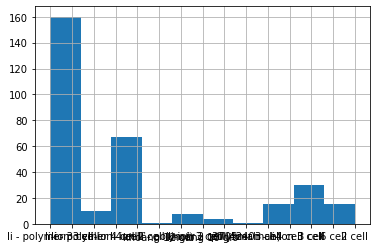

In [16]:
data['battery'].hist()

**Cột battery chúng em đã bỏ ra vì có quá nhiều giá trị và không phân loại được**

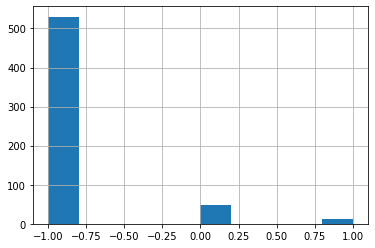

In [22]:
data['keyboard_light'].fillna(-1).hist()

**Cột keyboard light bỏ ra vì có quá nhiều giá trị thiếu**

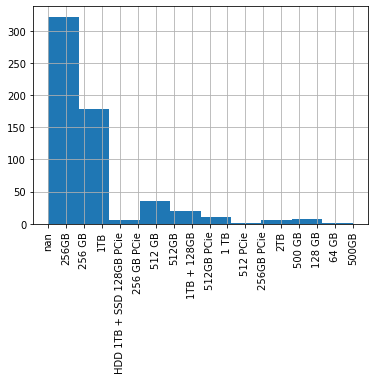

In [35]:
data['disk'].fillna('nan').hist()
plt.xticks(rotation=90)
plt.show()

Vì cột có nhiều giá trị khác nhau ở vị trí lẻ, nên ta sẽ làm tròn lại

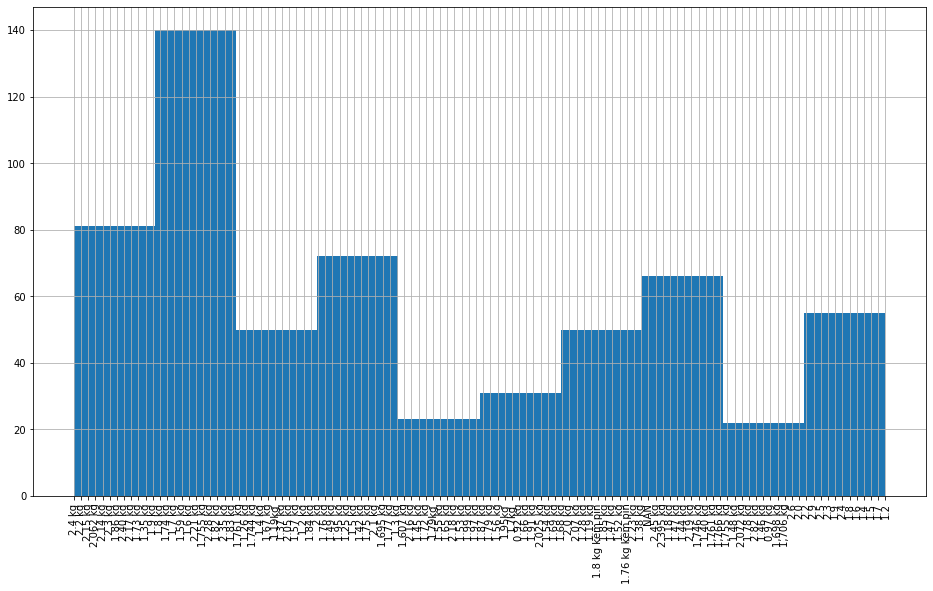

In [76]:
data['weight'].fillna('NAN').hist(figsize=(16, 9))
plt.xticks(rotation=90)
plt.show()

Ở cột khối lượng có nhiều giá trị lẻ và có chuỗi đơn vị nên chúng em sẽ bỏ đơn vị và làm tròn số kg.

**VD**: 

- 1.5kg -> 2

- 2.3 -> 2

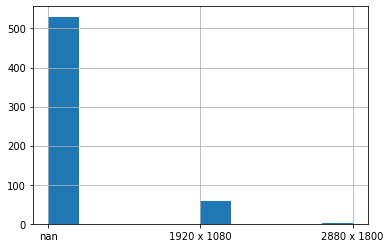

In [32]:
data['resolution'].fillna('nan').hist()

Ở cột độ phân giải, ta có quá nhiều giá trị thiếu, giá trị có thì độ phân giải khác cao, nên ta sẽ quyết định bỏ cột này đi 

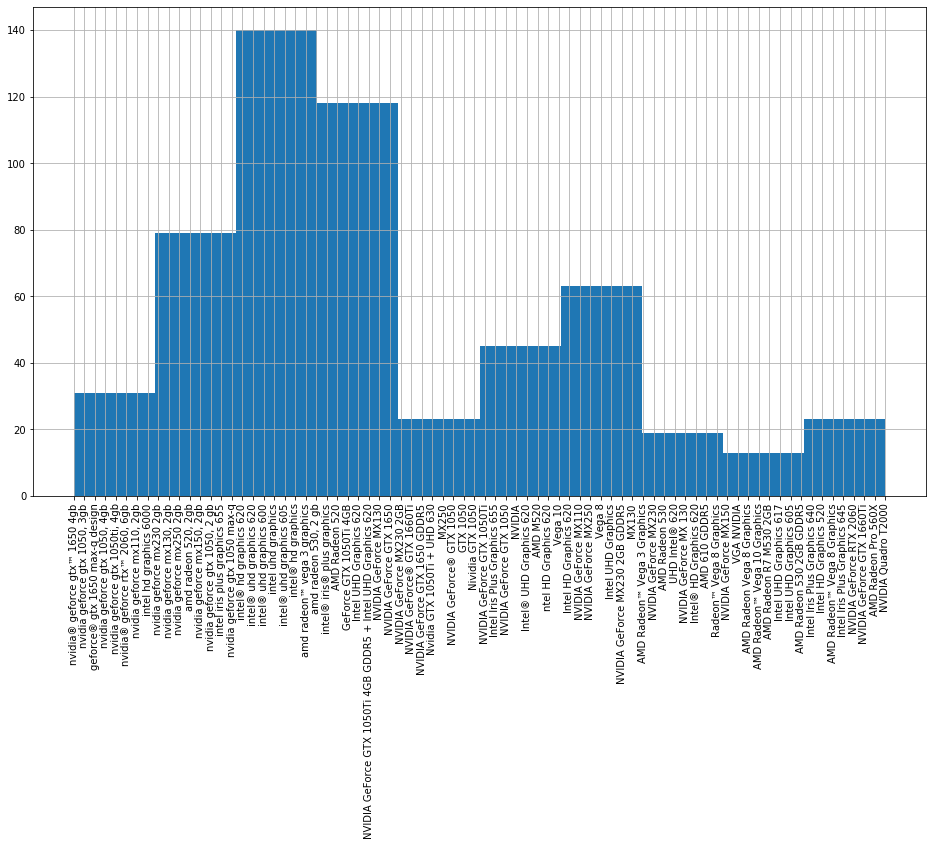

In [99]:
data['graphic'].hist(figsize=(16, 9))
plt.xticks(rotation=90)
plt.show()

Ở cột graphic, ta sẽ lấy thông tin hãng (NVIDIA, AMD, Intel) và số tương ứng (có từ 3 số trở lên)

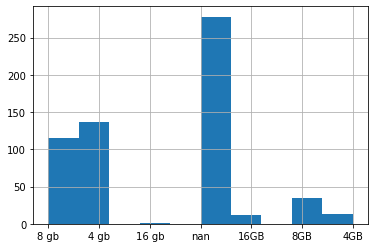

In [115]:
data['ram'].fillna('nan').hist()

## TIỀN XỬ LÝ

In [177]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer, StandardScaler
from sklearn.impute import SimpleImputer

import re
import math

In [169]:
class UnitRemoverAndSimpler(BaseEstimator, TransformerMixin):
    def fit(self, *_):
        return self
    
    def transform(self, data: pd.DataFrame) -> pd.DataFrame:
        df = data.drop(['resolution', 'battery', 'keyboard_light'], axis=1)
        df['disk'] = data['disk'].apply(self.process_disk)
        df['weight'] = data['weight'].apply(self.process_weight)
        df['graphic'] = data['graphic'].fillna('intel').apply(self.process_graphic)
        df['ram'] = data['ram'].fillna('0').apply(lambda r: int(re.sub(f'\D+', '', r)))
        df['ssd'] = data['ssd'].fillna(0).apply(lambda ssd: 1 if ssd != 0 else 0)
        
        group_cols = list(df.columns)
        group_cols.remove('category')
        
        df_unique = df.groupby(by=group_cols, as_index=False)\
            .agg({'category': set})\
            .reset_index()
        
        return df_unique.drop(['name', 'index'], axis=1)
        
    def process_disk(self, disk: str):
        if not disk:
            return disk
        search = re.search(r'(\d+)\s?([mgt]b).*', str(disk).lower())
        if search:
            value = int(search.group(1))
            unit = search.group(2)
            if unit == 'mb':
                return value / 2
            if unit == 'gb':
                return value
            if unit == 'tb':
                return value * 1024
            return value
        return np.nan
    
    def process_weight(self, w: str):
        w = re.sub(r'[^\.\,0-9]', '', str(w))
        if w == '':
            return 0
        w = re.sub(',', '.', w)
        w = float(w)
        w = int(round(w))
        return w
    
    def process_graphic(self, g: str):
        brand = 'intel'
        g = g.lower()
        if 'nvidia' in g or 'geforce' in g or 'gtx' in g:
            brand = 'nvidia'
        elif 'amd' in g or 'radeon' in g:
            brand = 'amd'
        
        number = ''
        number_s = re.search(r'(\d{3,})', g)
        if (number_s):
            number = int(number_s.group(1))
            number = ' ' + str(math.floor(number / 100) * 100)
            
        return f'{brand}{number}'

In [170]:
data_processed = UnitRemoverAndSimpler().fit_transform(data)
data_processed

,cpu_name,cpu_type,disk,graphic,ram,ssd,weight,category
0,AMD Quad Core,R5-3500U,256.0,nvidia 1000,0,1,0,{hoc-tap-van-phong}
1,AMD Ryzen™ 3,3200U,256.0,amd,0,1,0,"{hoc-tap-van-phong, do-hoa-ky-thuat}"
2,AMD Ryzen™ 5,2500U,1024.0,amd,0,1,2,{hoc-tap-van-phong}
3,AMD Ryzen™ 5,3500U,256.0,intel,0,1,1,"{hoc-tap-van-phong, do-hoa-ky-thuat}"
4,AMD Ryzen™ 5,3500U,256.0,intel,0,1,2,{hoc-tap-van-phong}
...,...,...,...,...,...,...,...,...
180,Intel Core i7,9750H,1024.0,nvidia 1600,8,0,2,"{do-hoa-ky-thuat, laptop-gaming}"
181,Intel Core i7,9750H,1024.0,nvidia 1600,8,1,3,"{do-hoa-ky-thuat, laptop-gaming}"
182,Intel Pentium,N5000,64.0,intel 600,0,1,1,{hoc-tap-van-phong}
183,i3,8145U,512.0,intel,0,1,2,{hoc-tap-van-phong}


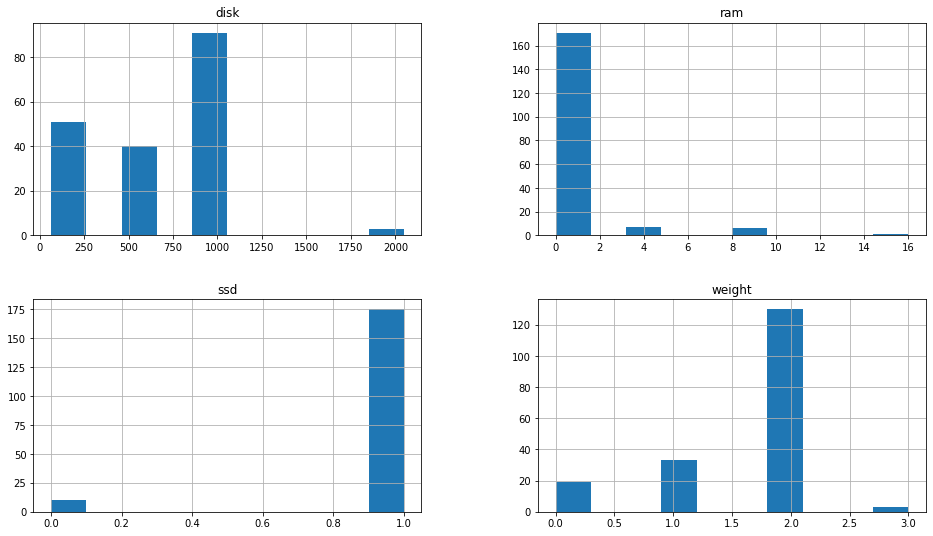

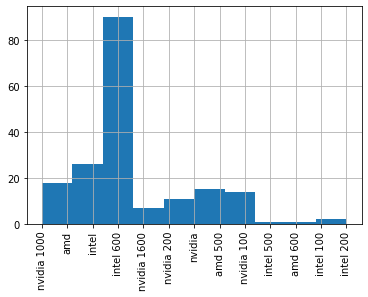

In [171]:
data_processed.hist(figsize=(16,9))
plt.show()

data_processed['graphic'].hist()
plt.xticks(rotation=90)
plt.show()

In [172]:
data_processed

,cpu_name,cpu_type,disk,graphic,ram,ssd,weight,category
0,AMD Quad Core,R5-3500U,256.0,nvidia 1000,0,1,0,{hoc-tap-van-phong}
1,AMD Ryzen™ 3,3200U,256.0,amd,0,1,0,"{hoc-tap-van-phong, do-hoa-ky-thuat}"
2,AMD Ryzen™ 5,2500U,1024.0,amd,0,1,2,{hoc-tap-van-phong}
3,AMD Ryzen™ 5,3500U,256.0,intel,0,1,1,"{hoc-tap-van-phong, do-hoa-ky-thuat}"
4,AMD Ryzen™ 5,3500U,256.0,intel,0,1,2,{hoc-tap-van-phong}
...,...,...,...,...,...,...,...,...
180,Intel Core i7,9750H,1024.0,nvidia 1600,8,0,2,"{do-hoa-ky-thuat, laptop-gaming}"
181,Intel Core i7,9750H,1024.0,nvidia 1600,8,1,3,"{do-hoa-ky-thuat, laptop-gaming}"
182,Intel Pentium,N5000,64.0,intel 600,0,1,1,{hoc-tap-van-phong}
183,i3,8145U,512.0,intel,0,1,2,{hoc-tap-van-phong}


### TRAIN DATA

In [173]:
from sklearn.model_selection import train_test_split

In [174]:
# dữ liệu không có nhãn huấn luyện
X_df = data_processed.drop('category', axis=1)

# cột nhãn (đã tiền xử lý chuỗi)
Y_df = np.array(data_processed.category)
binarier = MultiLabelBinarizer()
Y_df = binarier.fit_transform(Y_df)

print(X_df.shape)
print(Y_df.shape)

(185, 7)
(185, 3)


Tạo bộ test tỉ lệ 7:3

In [175]:
(X_train, X_test, Y_train, Y_test) = train_test_split(X_df, Y_df, test_size=0.33)

### THUẬT TOÁN

Vì bài toán này, laptop sẽ có thể đồng thời nằm ở 2-3 phân lớp khác nên đây là bài toán `multi-class classification`

Ta sẽ khảo sát **5** thuật toán multi-class:

- `LinearRegression`

- `LinearSVC`

- `PassiveAggressiveClassifier`

- `SGDClassifier`

- `MultinomialNB`

In [183]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LinearRegression, SGDClassifier, PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

### PIPELINE XỬ LÝ

In [188]:
str_pipeline = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(handle_unknown='ignore'), ['cpu_name', 'cpu_type', 'graphic']),
        remainder='passthrough'
    ),
)

preprocess = make_pipeline(
    str_pipeline,
    SimpleImputer(strategy='most_frequent')
)

In [189]:
model = Pipeline([
    ('preprocess', preprocess),
    ('ovr', OneVsRestClassifier(LinearRegression()))
])

### TA SẼ KHẢO SÁT ĐỘ LỖI TỪNG THUẬT TOÁN

In [194]:
algos = [
    LinearRegression(),
    LinearSVC(),
    MultinomialNB(),
    SGDClassifier(),
    PassiveAggressiveClassifier(),
]
algo_names = list(map(lambda algo: type(algo).__name__, algos))

best_algo = None
best_test_error = float('inf')
test_errs = []
train_errs = []

for algo in algos:
    model.set_params(ovr__estimator=algo)
    model.fit(X_train, Y_train)
    
    Y_pred_train = model.predict(X_train)
    Y_pred_test = model.predict(X_test)
    
    train_err = np.mean(Y_pred_train != Y_train)
    test_err = np.mean(Y_pred_test != Y_test)
    
    train_errs.append(train_err)
    test_errs.append(test_err)
    
    if best_test_error > test_err:
        best_test_error = test_err
        best_algo = algo
        
print(best_test_error)
print(type(best_algo).__name__)

0.11827956989247312
LinearRegression


/home/noobcoder/0_Project/school/DataAnalyst/DACK/.venv/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### KẾT QUẢ KHẢO SÁT

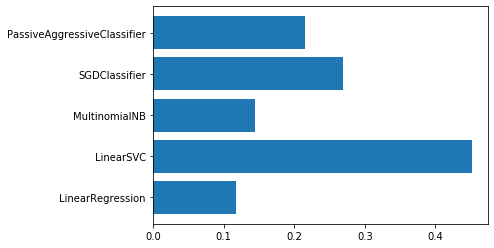

In [236]:
plt.barh(algo_names, test_errs)
plt.show()

## KIỂM THỬ BẰNG TAY

In [226]:
model.set_params(ovr__estimator=best_algo)
model.fit(X_train, Y_train);

In [232]:
# placeholder = data_processed.copy()
sample = pd.DataFrame([{
    'cpu_name': 'intel core i5',
    'cpu_type': '6300HQ',
    'disk': 1024, # 1TB
    'ram': 8,
    'ssd': 1,
    'weight': 2,
    'graphic': 'nvidia 950'
}])
sample = sample[X_df.columns]
sample

,cpu_name,cpu_type,disk,graphic,ram,ssd,weight
0,intel core i5,6300HQ,1024,nvidia 950,8,1,2


In [235]:
pred = model.predict(sample)
binarier.inverse_transform(pred)

[('do-hoa-ky-thuat', 'hoc-tap-van-phong')]